### Dependencies

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.qhull import Delaunay

/var/folders/5s/7z5kptnj64x87q0xrkz1nwfc0000gn/T/ipykernel_31904/3867941674.py:5: DeprecationWarning: Please import `Delaunay` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.qhull import Delaunay


# Project 3 - Face Morphing

## Part 1. Defining Correspondences

In [2]:
face_a = cv2.imread('../data/filip.jpg')
face_b = cv2.imread('../data/emelie.jpg')

# the points are defined in a json file called filip_emelie.json
with open('../data/filip_emelie.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

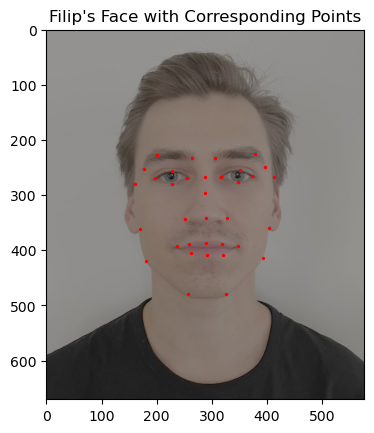

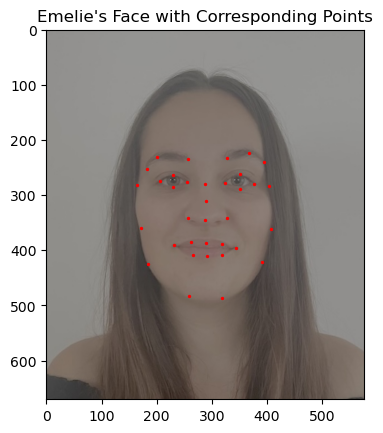

In [3]:
import cv2
import matplotlib.pyplot as plt

# Helper function to plot points on an image
def plot_points_on_face(image, points, title="Image with Points"):
    # Convert image to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot image
    plt.imshow(image_rgb)
    plt.scatter(points[:, 0], points[:, 1], color='red', marker='o', s=2)
    
    # Set axis limits to match image size
    plt.xlim(0, image.shape[1])  # Width of the image
    plt.ylim(image.shape[0], 0)  # Height of the image, inverted Y-axis
    
    # Set title and show the plot
    plt.title(title)
    plt.show()

# Plot Filip's points on Filip's face
plot_points_on_face(face_a, im1_points, title="Filip's Face with Corresponding Points")

# Plot Emelie's points on Emelie's face
plot_points_on_face(face_b, im2_points, title="Emelie's Face with Corresponding Points")

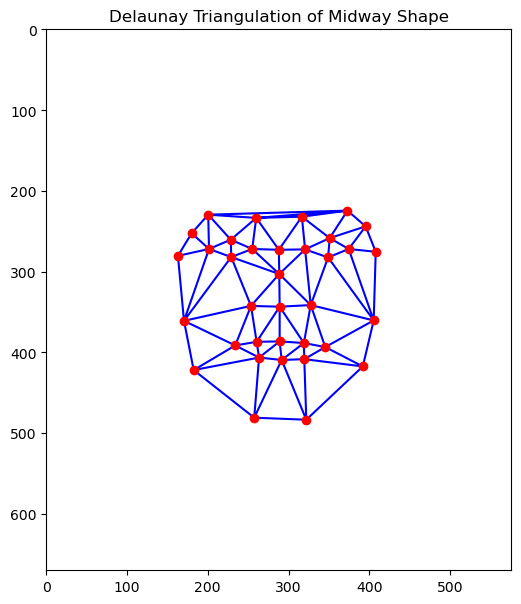

In [4]:
# Compute the midway shape points (average of corresponding points)
midway_points = (im1_points + im2_points) / 2

# Perform Delaunay triangulation on the midway points
tri = Delaunay(midway_points)

# Visualize the triangulation on the midway shape
plt.figure(figsize=(6, 8))  # Adjust the figure size to match the image proportions

# Plot the Delaunay triangulation
plt.triplot(midway_points[:, 0], midway_points[:, 1], tri.simplices, color='blue')
plt.scatter(midway_points[:, 0], midway_points[:, 1], color='red')

# Set the aspect ratio to match the image dimensions
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match image size (width x height = 576 x 670)
plt.xlim(0, 576)
plt.ylim(670, 0)  # Invert Y-axis to match image coordinates

# Display the plot
plt.title("Delaunay Triangulation of Midway Shape")
plt.show()

## Part 2. Computing the "Mid-way Face"

In [5]:
import numpy as np

def compute_affine(tri1_pts, tri2_pts):
    # Create matrices for triangle points
    tri1 = np.vstack((tri1_pts.T, np.ones((1, 3))))
    tri2 = np.vstack((tri2_pts.T, np.ones((1, 3))))
    
    # Compute the affine transformation matrix A
    A = np.dot(tri2, np.linalg.inv(tri1))
    
    return A


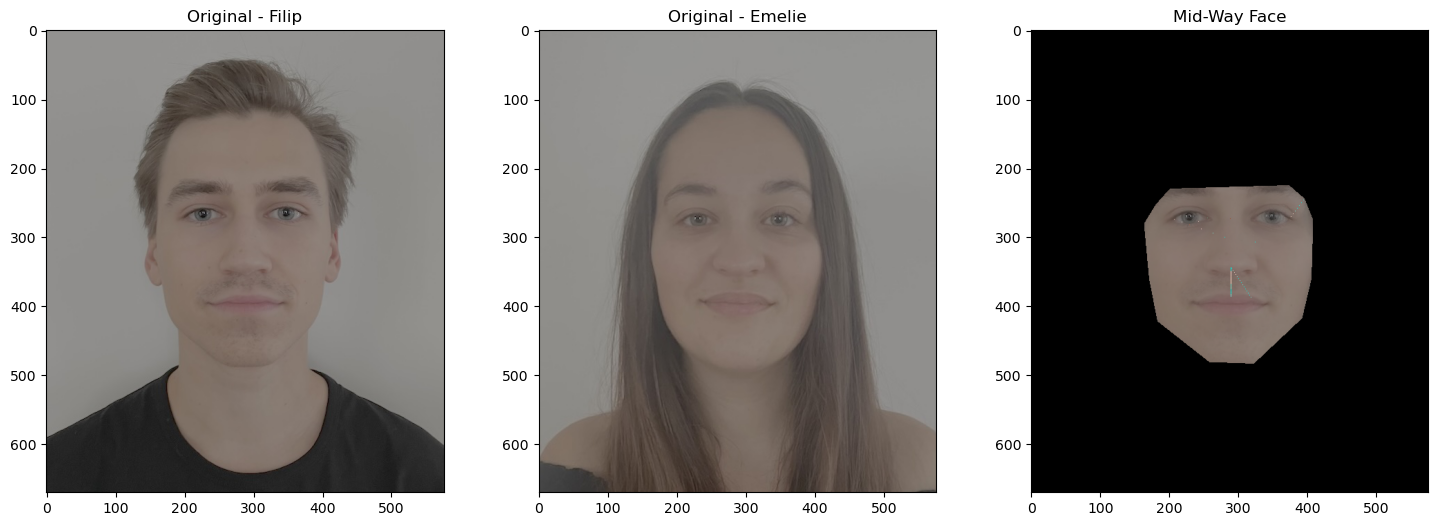

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon

# Helper function to warp a triangle from one image to another
def warp_triangle(img, src_tri, dst_tri, dst_shape):
    # Compute affine transformation matrix
    A = compute_affine(src_tri, dst_tri)
    
    # Create mask for destination triangle
    rr, cc = polygon(dst_tri[:, 1], dst_tri[:, 0], shape=dst_shape)
    
    # Apply inverse warp to find the corresponding pixel in the source image
    coords = np.vstack((cc, rr, np.ones(len(rr))))
    warped_coords = np.dot(np.linalg.inv(A), coords)
    
    # Interpolation to find pixel values in the source image
    x_warped = np.clip(warped_coords[0].astype(int), 0, img.shape[1]-1)
    y_warped = np.clip(warped_coords[1].astype(int), 0, img.shape[0]-1)
    
    # Warp pixels from the source image
    warped_img = np.zeros_like(img)
    warped_img[rr, cc] = img[y_warped, x_warped]
    
    return warped_img

# Helper function to perform the morphing process
def compute_midway_face(img_a, img_b, points_a, points_b, triangles):
    # Compute the average points (average shape)
    avg_points = (points_a + points_b) / 2
    
    # Empty images to store the warped results
    warped_a = np.zeros_like(img_a)
    warped_b = np.zeros_like(img_b)
    
    # Loop over each triangle and warp both images to the average shape
    for tri_indices in triangles.simplices:
        # Get the points of the triangles in both images and the average
        tri_a = points_a[tri_indices]
        tri_b = points_b[tri_indices]
        tri_avg = avg_points[tri_indices]
        
        # Warp the triangles in both images to the average shape
        warped_a += warp_triangle(img_a, tri_a, tri_avg, img_a.shape)
        warped_b += warp_triangle(img_b, tri_b, tri_avg, img_b.shape)
    
    # Average the colors of the warped images
    midway_face = (warped_a / 2 + warped_b / 2).astype(np.uint8)
    
    return midway_face

# Load the keypoints (assumed to be loaded from a json or manually clicked)
points_a = np.array(points['im1Points'])
points_b = np.array(points['im2Points'])

# Compute the Delaunay triangulation (using the average shape)
average_points = (points_a + points_b) / 2
tri = Delaunay(average_points)

# Compute the mid-way face
midway_face = compute_midway_face(face_a, face_b, points_a, points_b, tri)

# Display the original and mid-way face
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(face_a, cv2.COLOR_BGR2RGB))
plt.title("Original - Filip")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(face_b, cv2.COLOR_BGR2RGB))
plt.title("Original - Emelie")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(midway_face, cv2.COLOR_BGR2RGB))
plt.title("Mid-Way Face")

plt.show()


## Part 3. The Morph Sequence

In [7]:
import numpy as np
import cv2
from scipy.spatial import Delaunay
import skimage.draw

def compute_affine(tri1_pts, tri2_pts):
    """Computes the affine transformation matrix A that maps tri1_pts to tri2_pts."""
    ones = np.ones((3, 1))
    tri1_pts_aug = np.hstack([tri1_pts, ones])  # Convert to homogeneous coordinates
    tri2_pts_aug = np.hstack([tri2_pts, ones])  # Convert to homogeneous coordinates
    A = np.linalg.lstsq(tri1_pts_aug, tri2_pts_aug, rcond=None)[0].T
    return A

def warp_triangle(src, src_tri, dst_tri, dst_shape):
    """Warp a triangular region from the source image to the destination."""
    # Bounding box for destination triangle
    r = cv2.boundingRect(np.float32([dst_tri]))
    
    # Offsets and affine transform
    dst_tri_offset = np.array([[p[0] - r[0], p[1] - r[1]] for p in dst_tri])
    src_tri_offset = np.array([[p[0], p[1]] for p in src_tri])
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_offset), np.float32(dst_tri_offset))
    
    # Warp source image triangle to the size of the destination bounding box
    warped_triangle = cv2.warpAffine(src, warp_mat, (r[2], r[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Create a mask for the triangle and place the warped triangle on the destination image
    mask = np.zeros((r[3], r[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), 1, 16, 0)
    dest_img_part = np.zeros_like(dst_shape)
    dest_img_part[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask)
    
    return dest_img_part

def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    # Compute the average shape points
    intermediate_pts = (1 - warp_frac) * np.array(im1_pts) + warp_frac * np.array(im2_pts)
    
    # Create the destination image with float64 precision for computation
    morphed_im = np.zeros_like(im1, dtype=np.float64)
    
    # Create a mask to define the region where the face is morphed
    mask = np.zeros(im1.shape[:2], dtype=np.uint8)
    
    for t in tri.simplices:
        tri1_pts = np.array([im1_pts[t[0]], im1_pts[t[1]], im1_pts[t[2]]])
        tri2_pts = np.array([im2_pts[t[0]], im2_pts[t[1]], im2_pts[t[2]]])
        intermediate_tri_pts = np.array([intermediate_pts[t[0]], intermediate_pts[t[1]], intermediate_pts[t[2]]])
        
        # Warp the triangles from im1 and im2 to the intermediate shape
        warped_im1 = warp_triangle(im1, tri1_pts, intermediate_tri_pts, morphed_im)
        warped_im2 = warp_triangle(im2, tri2_pts, intermediate_tri_pts, morphed_im)
        
        # Blend the two warped images using dissolve_frac
        blended_triangle = (1 - dissolve_frac) * warped_im1.astype(np.float64) + dissolve_frac * warped_im2.astype(np.float64)
        
        # Create a mask of the triangle area and add to the final image
        cv2.fillConvexPoly(mask, np.int32(intermediate_tri_pts), 255)
        morphed_im += blended_triangle

    # Clip values to [0, 255] and convert back to uint8
    morphed_im = np.clip(morphed_im, 0, 255).astype(np.uint8)

    # Handle the background part: dissolve the non-face areas
    background = (1 - dissolve_frac) * im1.astype(np.float64) + dissolve_frac * im2.astype(np.float64)
    
    # Create an inverted mask to cover non-face areas
    mask_inv = cv2.bitwise_not(mask)
    
    # Combine the morphed face with the dissolved background
    face_part = cv2.bitwise_and(morphed_im, morphed_im, mask=mask)
    background_part = cv2.bitwise_and(background.astype(np.uint8), background.astype(np.uint8), mask=mask_inv)
    
    # Combine both parts together to get the final morphed image
    result = cv2.add(face_part, background_part)

    return result

# Compute the Delaunay triangulation based on average points
mean_pts = (np.array(im1_points) + np.array(im2_points)) / 2
tri = Delaunay(mean_pts)

# Test with some warp and dissolve fractions (e.g., halfway)
morphed_im = morph(face_a, face_b, im1_points, im2_points, tri, warp_frac=0.5, dissolve_frac=0.5)

# Show the result
# cv2.imshow("Morphed Image", morphed_im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [8]:
import imageio
import cv2

def create_morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames=30):
    frames = []
    for frac in np.linspace(0, 1, num_frames):
        morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac=frac, dissolve_frac=frac)
        # Convert BGR to RGB
        morphed_im_rgb = cv2.cvtColor(morphed_im, cv2.COLOR_BGR2RGB)
        frames.append(morphed_im_rgb)
    
    return frames

# Generate morph frames
frames = create_morph_sequence(face_a, face_b, im1_points, im2_points, tri, num_frames=30)

# Save as GIF
imageio.mimsave('morph_sequence.gif', frames, fps=10)

Testing

In [11]:
import numpy as np
import imageio
from scipy.spatial import Delaunay

def morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames):
    """Creates a morph sequence between two images over a specified number of frames."""
    height, width, _ = im1.shape
    video_frames = []
    
    for frame_num in range(num_frames):
        # Linearly interpolate warp_frac and dissolve_frac
        warp_frac = frame_num / (num_frames - 1)
        dissolve_frac = frame_num / (num_frames - 1)
        
        # Compute the intermediate points
        intermediate_pts = (1 - warp_frac) * np.array(im1_pts) + warp_frac * np.array(im2_pts)
        
        # Create an empty image for the morphed result
        morphed_im = np.zeros_like(im1, dtype=np.float64)
        
        for t in tri.simplices:
            # Get the triangle vertices for each image
            tri1_pts = np.array([im1_pts[t[0]], im1_pts[t[1]], im1_pts[t[2]]])
            tri2_pts = np.array([im2_pts[t[0]], im2_pts[t[1]], im2_pts[t[2]]])
            intermediate_tri_pts = np.array([intermediate_pts[t[0]], intermediate_pts[t[1]], intermediate_pts[t[2]]])

            # Warp the triangles from both images to the intermediate shape
            warped_im1 = warp_triangle(im1, tri1_pts, intermediate_tri_pts, morphed_im)
            warped_im2 = warp_triangle(im2, tri2_pts, intermediate_tri_pts, morphed_im)
            
            # Blend the two warped triangles using dissolve_frac
            blended_triangle = (1 - dissolve_frac) * warped_im1.astype(np.float64) + dissolve_frac * warped_im2.astype(np.float64)
            
            # Add the blended triangle to the final image
            morphed_im += blended_triangle
        
        # Clip values to [0, 255] and convert to uint8
        morphed_im = np.clip(morphed_im, 0, 255).astype(np.uint8)
        
        # Append the morphed image frame to the video_frames list
        video_frames.append(morphed_im)

    return video_frames

def create_morph_gif(im1, im2, im1_pts, im2_pts, num_frames=30, output_file="morph_output.gif"):
    """Generates a morphing sequence between two images and saves it as a GIF."""
    # Compute the Delaunay triangulation for the mean shape
    mean_pts = (np.array(im1_pts) + np.array(im2_pts)) / 2
    tri = Delaunay(mean_pts)
    
    # Get the sequence of morphed images
    frames = morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames)
    
    # Save the frames as a GIF using imageio
    imageio.mimsave(output_file, frames, duration=0.1)  # duration defines the delay between frames (in seconds)

# Example usage:
create_morph_gif(face_a, face_b, im1_points, im2_points, num_frames=30, output_file="morph_output.gif")